In [172]:

import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import os
import scipy
import cv2 as cv

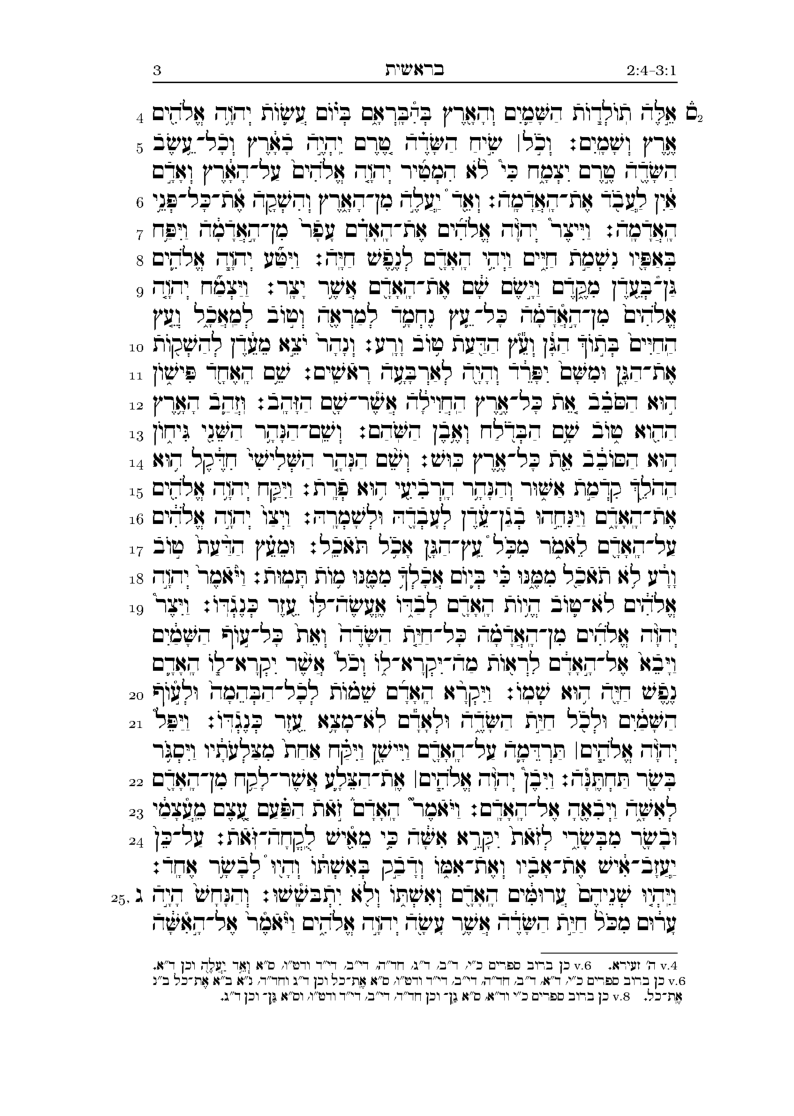

In [66]:
sample = plt.imread("../datasets/binarized_bible_pages/page_10.png")

def show_page_sample(img, s=2):
    # larger figure size and keep aspect ratio
    plt.figure(figsize=(10,s*4))
    plt.imshow(img, cmap="gray")
    plt.axis("off")
    plt.show()

show_page_sample(sample, s=10)

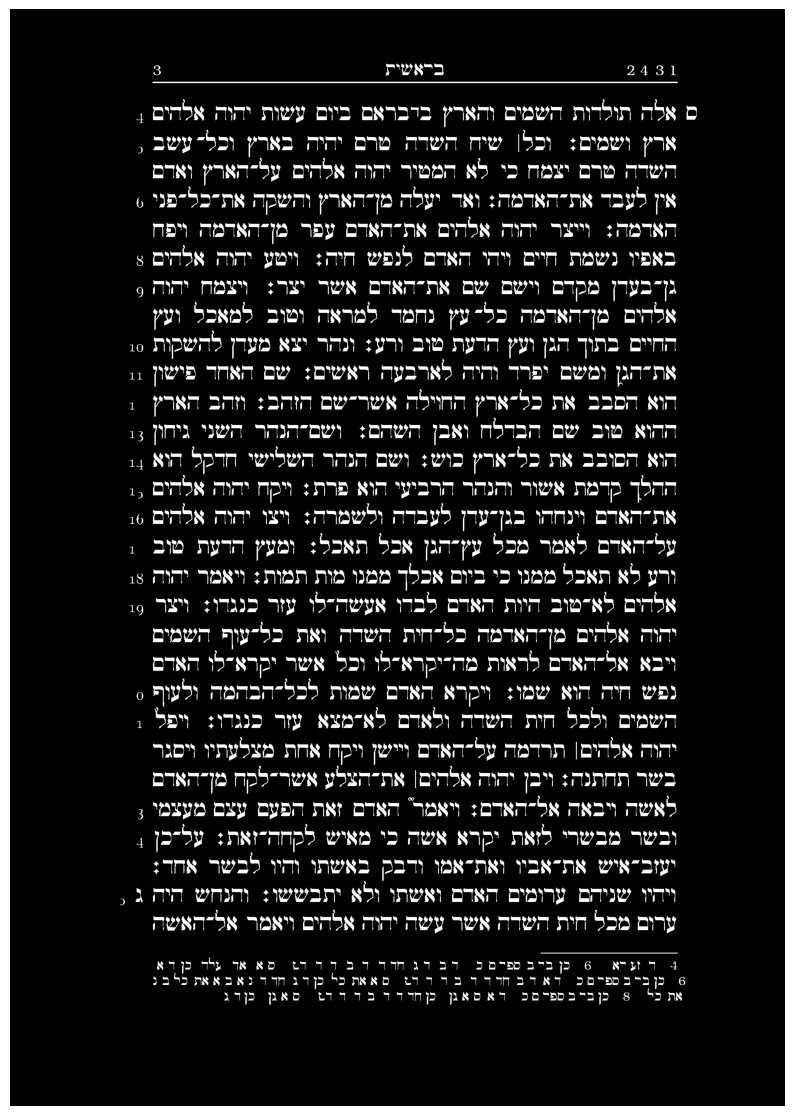

In [93]:
def walk_char(acc, i, j, visited_symbols=[], visited_acc=None):
    stack = [(i,j)]
    while stack:
        i,j = stack.pop()
        # check if i and j are within bounds
        if i < 0 or i >= acc.shape[0] or j < 0 or j >= acc.shape[1]:
            continue

        # if visited or reached a background pixel then return    
        if acc[i,j] == 0 or visited_acc[i,j] == 1:
            continue

        visited_acc[i,j] = 1 # visited
        visited_symbols.append((i,j))

        stack.append((i-1, j))
        stack.append((i+1, j))
        stack.append((i, j-1))
        stack.append((i, j+1))
    
def remove_ornaments(page, threshold=10):
    acc = page.copy()
    visited_acc = np.zeros_like(acc)
    delete_list = []

    for i in range(acc.shape[0]):
        for j in range(acc.shape[1]):
            if acc[i,j] == 1 and visited_acc[i,j] == 0:
                
                visited_positions = []
                walk_char(acc, i, j, visited_positions, visited_acc=visited_acc)

                if len(visited_positions) < threshold:
                    delete_list.extend(visited_positions)

            visited_acc[i,j] = 1 # visited

    for i,j in delete_list:
        acc[i,j] = 0
    acc = (acc > 0)
    acc = acc.astype(np.uint8)
    return acc


def preprocessed_page(page):
    # convert to grayscale 
    # page = np.dot(page[...,:3], [0.299, 0.587, 0.114])
    page = np.min(page, axis=2)
    # invert
    page = 1 - page
    # binarize to 0 and 1
    page = np.where(page > 0.5, 1, 0)
    return page


preprocessed_page = preprocessed_page(sample)
preprocessed_page = remove_ornaments(preprocessed_page, threshold=42)

show_page_sample(preprocessed_page, s=50)

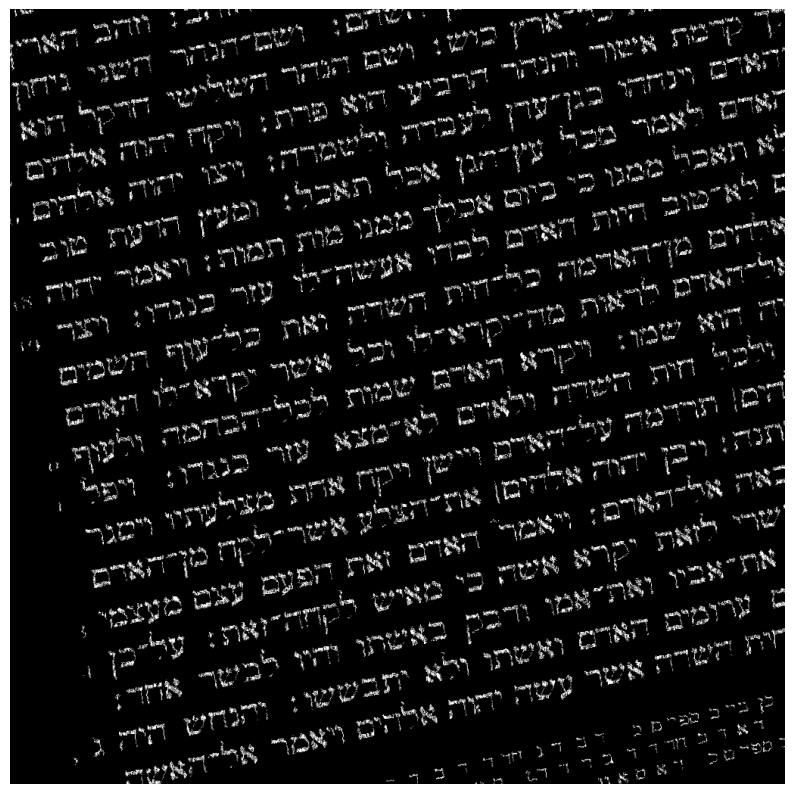

In [254]:
# adjust k_1 and k_2 to achieve the required distortion
def concave_effect(img, k_1 = 0.2, k_2 = 0.05):

    h,w = img.shape
    x,y = np.meshgrid(np.float32(np.arange(w)),np.float32(np.arange(h))) # meshgrid for interpolation mapping


    # center and scale the grid for radius calculation (distance from center of image)
    x_c = w/2 
    y_c = h/2 
    x = x - x_c
    y = y - y_c
    x = x/x_c
    y = y/y_c

    radius = np.sqrt(x**2 + y**2) # distance from the center of image

    m_r = 1 + k_1*radius + k_2*radius**2 # radial distortion model

    # apply the model 
    x= x * m_r 
    y = y * m_r

    # reset all the shifting
    x= x*x_c + x_c
    y = y*y_c + y_c

    distorted = scipy.ndimage.map_coordinates(img, [y.ravel(),x.ravel()])
    distorted.resize(img.shape)

    return distorted

def corrupt_binary_img(img, threshold=0.5):
    # sample noise with multivariate distribution numbers between 0 and 1
    noise = np.random.multivariate_normal(mean=[0,0], cov=[[1,0],[0,1]], size=img.shape)
    noise = np.min(noise, axis=2)
    noise = np.where(noise > threshold, 1, 0)
    noise = noise.astype(np.uint8)
    return img * noise

def p_corruption(img, p=0.2):
    # uniformly sample noise
    noise = np.random.uniform(low=0, high=1, size=img.shape)
    noise = np.where(noise <= p, 0, 1)
    noise = noise.astype(np.uint8)
    return img * noise

def brush_img(img, s=5):

    # shift image by s pixels
    shifted = np.roll(img, s, axis=0)
    out = np.prod([img, shifted], axis=0)
    return out

def scripturize_page(page):
    # page = corrupt_binary_img(page, threshold=1e-5)
    page = p_corruption(page, p=0.2)
    page = brush_img(page, s=2)
    # page = concave_effect(page)
    return page

transform = transforms.Compose([
    transforms.ToTensor(),
    # random perspective
    transforms.RandomPerspective(distortion_scale=0.2, p=0.5, fill=0),
    # random rotation
    transforms.RandomRotation(degrees=10, fill=0),
    # random affine
    transforms.RandomAffine(degrees=5, translate=(0.1,0.1), scale=(0.9,1.1), shear=10, fill=0),
    # Random crop
    transforms.RandomCrop(1024,),
    # Random center crop
    # transforms.CenterCrop(1024,),
    transforms.Normalize((0.5,), (0.5,)),
])

scripturized_page = scripturize_page(preprocessed_page)
# add channel axis
# scripturized_page = scripturized_page[np.newaxis, ...]
scripturized_page = transform(scripturized_page.astype(np.float32))
show_page_sample(scripturized_page[0], s=50)
    